In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
df = pd.read_csv('default_credit.csv')
df.drop(columns='index', inplace=True)
df.default = df.default.astype('category').cat.codes
df.student = df.student.astype('category').cat.codes
df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [66]:
df.describe()

,default,student,balance,income
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.033300,0.294400,835.374886,33516.981876
std,0.179428,0.455795,483.714985,13336.639563
min,0.000000,0.000000,0.000000,771.967729
25%,0.000000,0.000000,481.731105,21340.462903
50%,0.000000,0.000000,823.636973,34552.644802
75%,0.000000,1.000000,1166.308386,43807.729272
max,1.000000,1.000000,2654.322576,73554.233495


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  int8   
 1   student  10000 non-null  int8   
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), int8(2)
memory usage: 175.9 KB


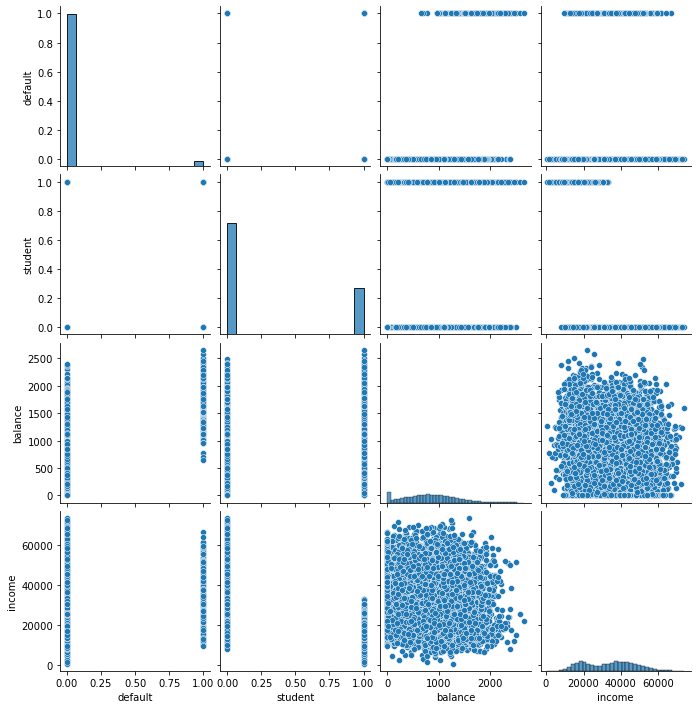

In [68]:
#Evaluamos correlación entre variables:
sns.pairplot(df)


In [69]:
y = df.default
X = df.drop(columns = 'default')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=11238)
pd.concat([pd.DataFrame(y_train), X_train], axis=1).info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 7721 to 8837
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  6700 non-null   int8   
 1   student  6700 non-null   int8   
 2   balance  6700 non-null   float64
 3   income   6700 non-null   float64
dtypes: float64(2), int8(2)
memory usage: 170.1 KB


In [70]:
priors_dict = {
    'no prior': None,
    'prior dist 50% 50%': [0.5, 0.5],
    'prior dist 60% 40%': [0.6, 0.4]
}
lda = {}
for key,val in priors_dict.items():
    print(key)
    lda[key] = LinearDiscriminantAnalysis(priors = val)
    lda[key].fit(X_train, y_train)
    y_pred = lda[key].predict(X_test)
    print(classification_report(y_test,y_pred, digits = 4))

no prior
              precision    recall  f1-score   support

           0     0.9739    0.9965    0.9851      3186
           1     0.7250    0.2544    0.3766       114

    accuracy                         0.9709      3300
   macro avg     0.8495    0.6255    0.6809      3300
weighted avg     0.9653    0.9709    0.9641      3300

prior dist 50% 50%
              precision    recall  f1-score   support

           0     0.9966    0.8387    0.9109      3186
           1     0.1696    0.9211    0.2865       114

    accuracy                         0.8415      3300
   macro avg     0.5831    0.8799    0.5987      3300
weighted avg     0.9681    0.8415    0.8893      3300

prior dist 60% 40%
              precision    recall  f1-score   support

           0     0.9950    0.8829    0.9356      3186
           1     0.2114    0.8772    0.3407       114

    accuracy                         0.8827      3300
   macro avg     0.6032    0.8801    0.6382      3300
weighted avg     0.9680    

In [71]:
# import warnings
# warnings.warn('', FutureWarning)
if False:
   fig, ax = plt.subplots(2, 2, figsize=(12, 10))
   plt.subplots_adjust(hspace=.5)
   sns.despine()
   for i, col in enumerate(df[['balance', 'income']]):
      ax[i][0].set_title('Boxplot de {0}'.format(col), size=12)
      sns.boxplot(df[col], orient='v', ax=ax[i][0]);
      ax[i][1].set_title('Distribucion de {0}'.format(col), size=12)
      sns.distplot(df[col], ax=ax[i][1]);

   fig, ax = plt.subplots(1, 2, figsize=(10, 7))
   plt.subplots_adjust(wspace=.5)
   sns.despine()
   for i, col in enumerate(df[['default', 'student']]):
      ax[i].set_title('Frecuencia de clases de {0}'.format(col), size=15)
      sns.barplot(df[col].unique(), df[col].value_counts(), orient='v', ax=ax[i])


In [72]:
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
# oversampler = SMOTE(random_state=11238, ratio='minority')
oversampler = SMOTE(sampling_strategy='auto', random_state=11238)
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_resample(X_train,y_train)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12962 entries, 0 to 12961
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  12962 non-null  int8   
 1   student  12962 non-null  int8   
 2   balance  12962 non-null  float64
 3   income   12962 non-null  float64
dtypes: float64(2), int8(2)
memory usage: 228.0 KB


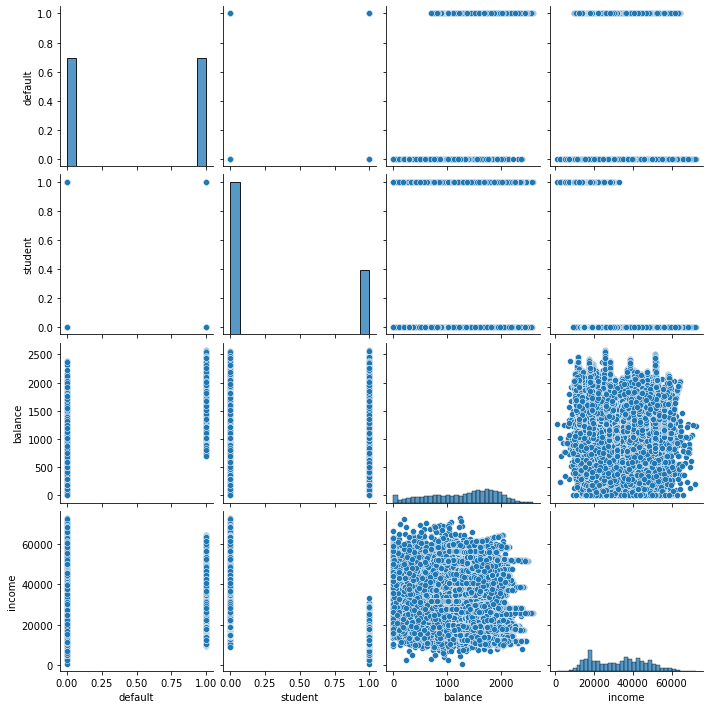

In [73]:
#Evaluamos correlación entre variables:
sns.pairplot(pd.concat([pd.DataFrame(y_train_oversamp), X_train_oversamp],axis=1))
pd.concat([pd.DataFrame(y_train_oversamp), X_train_oversamp],axis=1).info()

In [74]:
priors_dict = {
    'no prior': None,
    'prior dist 50% 50%': [0.5, 0.5],
    'prior dist 60% 40%': [0.6, 0.4]
}
lda_os = {}
for key,val in priors_dict.items():
    print(key)
    lda_os[key] = LinearDiscriminantAnalysis(priors = val)
    lda_os[key].fit(X_train_oversamp, y_train_oversamp)
    y_pred = lda_os[key].predict(X_test)
    print(classification_report(y_test,y_pred, digits = 4))

no prior
              precision    recall  f1-score   support

           0     0.9967    0.8431    0.9135      3186
           1     0.1736    0.9211    0.2921       114

    accuracy                         0.8458      3300
   macro avg     0.5851    0.8821    0.6028      3300
weighted avg     0.9682    0.8458    0.8920      3300

prior dist 50% 50%
              precision    recall  f1-score   support

           0     0.9967    0.8431    0.9135      3186
           1     0.1736    0.9211    0.2921       114

    accuracy                         0.8458      3300
   macro avg     0.5851    0.8821    0.6028      3300
weighted avg     0.9682    0.8458    0.8920      3300

prior dist 60% 40%
              precision    recall  f1-score   support

           0     0.9954    0.8745    0.9310      3186
           1     0.2016    0.8860    0.3285       114

    accuracy                         0.8748      3300
   macro avg     0.5985    0.8802    0.6297      3300
weighted avg     0.9679    

In [75]:
qda_os = QuadraticDiscriminantAnalysis()
qda_os.fit(X_train_oversamp, y_train_oversamp)
y_pred = qda_os.predict(X_test)
print(classification_report(y_test,y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9953    0.8723    0.9297      3186
           1     0.1988    0.8860    0.3248       114

    accuracy                         0.8727      3300
   macro avg     0.5971    0.8791    0.6273      3300
weighted avg     0.9678    0.8727    0.9088      3300



In [88]:
import json
models = {
    'lda_np': lda['no prior'],
    'lda_pr_5050': lda['prior dist 50% 50%'] ,
    'lda_pr_6040': lda['prior dist 60% 40%'],
    'lda_np_os': lda_os['no prior'] ,
    'lda_pr_5050_os': lda_os['prior dist 50% 50%'] ,
    'lda_pr_6040_os': lda_os['prior dist 60% 40%'] ,
    'qda_os': qda_os
}
from IPython.display import HTML

# Creamos un diccionario con las metricas de cada modelo
cr = {}
for key,val in models.items():
    cr[key] = classification_report(y_test,val.predict(X_test),digits =4, output_dict = True)

# Ordenar un poco el diccionario creado
for tag, model_metrics in cr.items():
    model_metrics_copy = model_metrics.copy()
    for metrics, values in model_metrics_copy.items():
        if metrics in ['0', '1', 'macro avg', 'weighted avg']:
            aux_dict = cr[tag][metrics].copy()
            for k,v in aux_dict.items():
                oldvalue = cr[tag][metrics]
                cr[tag][k + '_subtype_' + metrics] = cr[tag][metrics].pop(k)
                if 'support' in k:
                    del cr[tag][k + '_subtype_' + metrics]
            del cr[tag][metrics]
    cr[tag] = {key: value for key, value in sorted(cr[tag].items())}

# Se crea una tabla a partir del diccionario de metricas por modelo
table_str = '<table><tr><th>Models</th><th>' + '</th><th>'.join(models.keys()) + '</th></tr>'
metrics = list(cr[next(iter(cr))].keys())
models_tags = cr.keys()
for metric in metrics:
    table_str += '<tr>'
    table_str += f"<td>{metric}</td>"
    max_value = max([cr[model][metric] for model in models_tags])
    min_value = min([cr[model][metric] for model in models_tags])
    for model in models_tags:
        css_class=''
        if cr[model][metric] == max_value:
            css_class = ' style="color:red" '
        if cr[model][metric] == min_value:
            css_class = ' style="color:green" '
        
        table_str += f"<td{css_class}>{cr[model][metric]:.4f}</td>"
    table_str += '</tr>'
display(HTML(table_str))

Models,lda_np,lda_pr_5050,lda_pr_6040,lda_np_os,lda_pr_5050_os,lda_pr_6040_os,qda_os
accuracy,0.9709,0.8415,0.8827,0.8458,0.8458,0.8748,0.8727
f1-score_subtype_0,0.9851,0.9109,0.9356,0.9135,0.9135,0.9310,0.9297
f1-score_subtype_1,0.3766,0.2865,0.3407,0.2921,0.2921,0.3285,0.3248
f1-score_subtype_macro avg,0.6809,0.5987,0.6382,0.6028,0.6028,0.6297,0.6273
f1-score_subtype_weighted avg,0.9641,0.8893,0.9151,0.8920,0.8920,0.9102,0.9088
precision_subtype_0,0.9739,0.9966,0.9950,0.9967,0.9967,0.9954,0.9953
precision_subtype_1,0.7250,0.1696,0.2114,0.1736,0.1736,0.2016,0.1988
precision_subtype_macro avg,0.8495,0.5831,0.6032,0.5851,0.5851,0.5985,0.5971
precision_subtype_weighted avg,0.9653,0.9681,0.9680,0.9682,0.9682,0.9679,0.9678
recall_subtype_0,0.9965,0.8387,0.8829,0.8431,0.8431,0.8745,0.8723


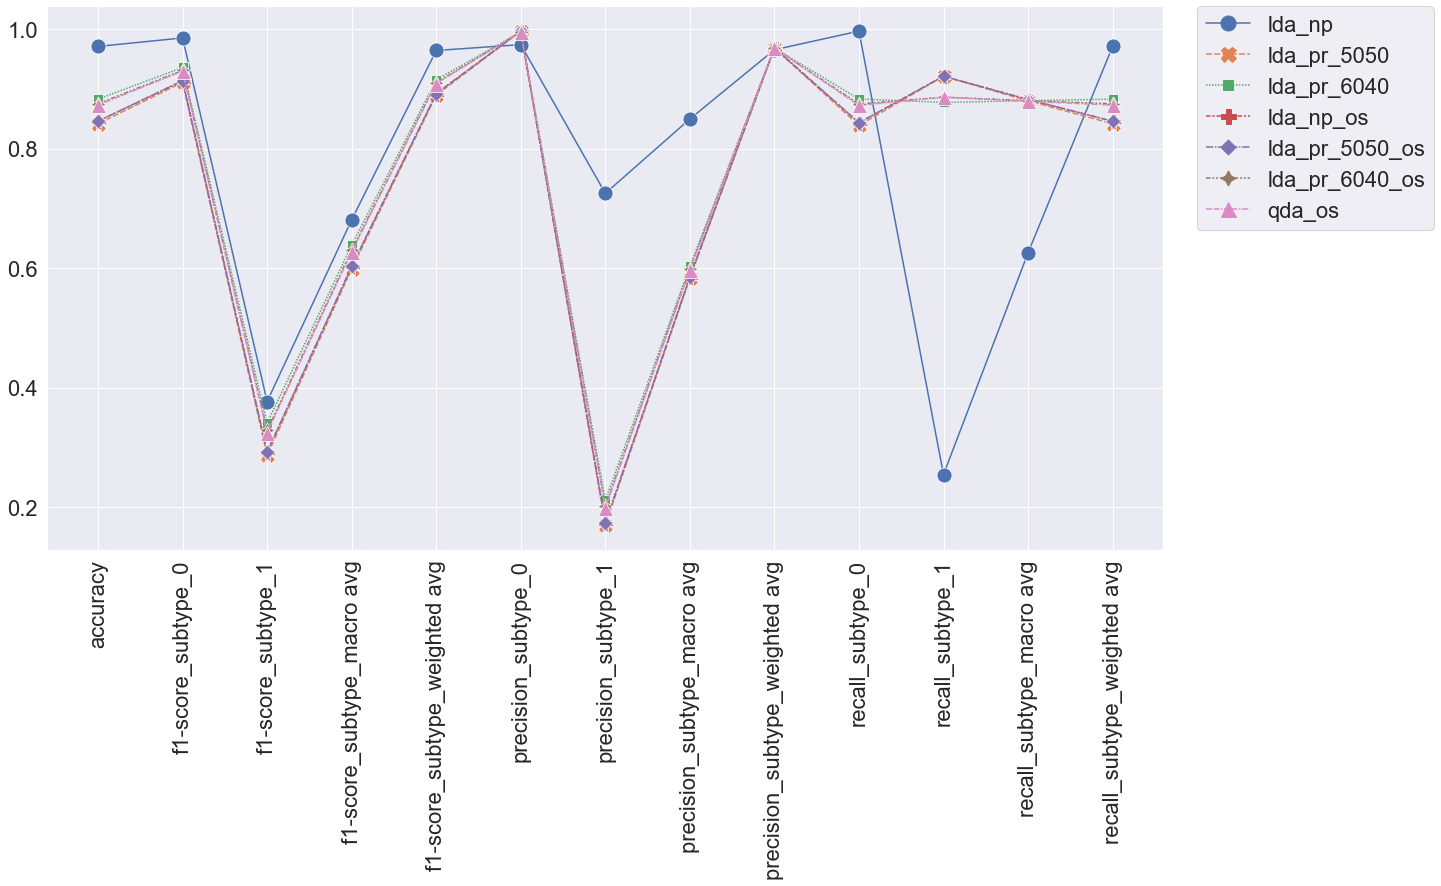

In [136]:
sns.set(context='notebook', font_scale=2, rc={'lines.markersize':15})

plt.figure(figsize=(20,10))
df2 = pd.DataFrame(cr)
sns.lineplot(data=df2, markers=True, sizes=(2.5, 2.5))
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)
